In [1]:
import dipy

In [2]:
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs

In [3]:
from fenics import *
from mshr import *
#from math import pi, sin, cos, sqrt
import math
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import os
import subprocess

In [4]:
fname = 'dMRI_data/motion_correction_test/registrated/correct.nii.gz' 
#fname = 'dMRI_data/ms-ras_data.nii.gz' 
data, affine = load_nifti(fname)
dims = data.shape
data_float = data.astype(np.float32)

In [5]:
bval_fname = 'dMRI_data/ms-ras.bval' 
reg_bvec_fname = 'dMRI_data/motion_correction_test/registrated/reornt_ms-ras.bvec' 

bvals, reg_bvecs = read_bvals_bvecs(bval_fname, reg_bvec_fname)
#print('b vectors: ', reg_bvecs)

In [6]:
parameters['allow_extrapolation'] = True

In [7]:
#Input volume number
k = 15

#B vector
b = 700
b2000_indcs = np.where(bvals==b)
b0_inds = np.where(bvals==0)
b0_ind = b0_inds[0][0]

In [8]:
#To select well distruted (farthes pointing vectors in 3D)
def calc_distances(p0, points):
    return np.minimum(((p0 - points)**2).sum(axis=1), ((-p0 - points)**2).sum(axis=1))
    #return ((p0 - points)**2).sum(axis=1) 
def farthestPts(pts, K):
    farthest_pts = np.zeros((K, 3))
    pts_inds = np.zeros(K)
    #farthest_pts[0] = pts[np.random.randint(len(pts))]
    farthest_pts[0] = pts[1]
    pts_inds[0] = 1
    distances = calc_distances(farthest_pts[0], pts)
    for i in range(1, K):
        farthest_pts[i] = pts[np.argmax(distances)]
        pts_inds[i] = np.argmax(distances)
        distances = np.minimum(distances, calc_distances(farthest_pts[i], pts))
    return farthest_pts, pts_inds
sub_bvecs, sub_indcs = farthestPts(reg_bvecs[bvals==b], k)
print('b sub vectors: ', sub_bvecs)
#print('b sub vector indecs ', sub_indcs)

#def calc_distances(p0, points):
#    return np.minimum(((p0 - points)**2).sum(axis=1), ((-p0 - points)**2).sum(axis=1))
#def closestPts(pts, K):
#    closest_pts = np.zeros((K, 3))
#    pts_inds = np.zeros(K)
#    #closest_pts[0] = pts[np.random.randint(len(pts))]
#    closest_pts[0] = pts[1]
#    pts_inds[0] = 1
#    distances = calc_distances(closest_pts[0], pts)
#    distances[int(pts_inds[0])] = 1000.0
#    for i in range(1, K):
#        closest_pts[i] = pts[np.argmin(distances)]
#        pts_inds[i] = np.argmin(distances)
#        #distances = np.minimum(distances, calc_distances(closest_pts[i], pts))
#        distances[int(pts_inds[i])] = 1000.0
#    return closest_pts, pts_inds
#sub_bvecs, sub_indcs = closestPts(bvecs[bvals==b], k)
#print('b sub vectors: ', sub_bvecs)

#Choose true indeces
true_sub_indcs = np.zeros(len(sub_indcs))
for i in range(len(sub_indcs)):
    true_sub_indcs[i] = b2000_indcs[0][int(sub_indcs[i])]
true_sub_indcs = np.append(true_sub_indcs, b0_ind)
sorted_true_sub_indcs = np.sort(true_sub_indcs)
#print('b sub vectors: ', sub_bvecs)
print('sorted b sub vector indeces ', sorted_true_sub_indcs)

b sub vectors:  [[-0.18574343  0.4923446   0.85035082]
 [-0.6849867   0.51917214 -0.51112974]
 [ 0.63181124  0.74418271 -0.21681058]
 [ 0.44714647  0.15045323  0.88171648]
 [-0.20241895  0.93260312  0.29879403]
 [-0.16174908 -0.20302294  0.96572189]
 [ 0.8332131   0.19388779 -0.5178447 ]
 [ 0.40741781  0.72227316  0.55886704]
 [-0.03663999  0.74495526 -0.6661074 ]
 [-0.98474824  0.16439807 -0.0569561 ]
 [-0.71949191  0.49922795  0.4828074 ]
 [ 0.7458839   0.51431935  0.42324118]
 [-0.66738858  0.72807149 -0.15653884]
 [-0.38186049  0.14063608  0.91345714]
 [ 0.62032477  0.53973253 -0.56910961]]
sorted b sub vector indeces  [ 0.  2.  3.  4.  7.  8. 10. 13. 15. 16. 18. 20. 23. 25. 28. 31.]


In [9]:
# Selecting one b0 and k+7 b700 voxels
sorted_true_sub_indcs = sorted_true_sub_indcs.astype(int)
sub_bvals = bvals[sorted_true_sub_indcs]
print(sub_bvals)

sub_data = data_float[:, :, :, sorted_true_sub_indcs]
print(sub_data.shape)

[  0. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700.]
(104, 104, 72, 16)


In [10]:
#Volume Index to predict
#nextIter_sub_bvecs, nextIter_sub_indcs = closestPts(reg_bvecs[bvals==b], k+1)
nextIter_sub_bvecs, nextIter_sub_indcs = farthestPts(reg_bvecs[bvals==b], k+1)
nextIter_true_sub_indcs = np.zeros(len(nextIter_sub_indcs))
for i in range(len(nextIter_sub_indcs)):
    nextIter_true_sub_indcs[i] = b2000_indcs[0][int(nextIter_sub_indcs[i])]
nextIter_true_sub_indcs = np.append(nextIter_true_sub_indcs, b0_ind)
sorted_nextIter_true_sub_indcs = np.sort(nextIter_true_sub_indcs)
print('b sub vector indecs ', sorted_nextIter_true_sub_indcs)
nextIter_sub_indcs = sorted_nextIter_true_sub_indcs.astype(int)
    
inter_sub_indcs = [i for i in sorted_nextIter_true_sub_indcs if i not in sorted_true_sub_indcs]
if len(inter_sub_indcs) != 0: 
    left_indcs = inter_sub_indcs[0]
else:
    left_indcs = np.arange(data.shape[3])
    left_indcs = np.delete(left_indcs, sorted_true_sub_indcs)
    print(left_indcs)
    left_indcs = left_indcs[0]
left_indcs = left_indcs.astype(int)
print("Predicted volume: ", left_indcs)

b sub vector indecs  [ 0.  2.  3.  4.  7.  8. 10. 11. 13. 15. 16. 18. 20. 23. 25. 28. 31.]
Predicted volume:  11


In [11]:
# Selecting one b0 and k+7 b700 voxels
sorted_true_sub_indcs = sorted_true_sub_indcs.astype(int)
sub_bvals = bvals[sorted_true_sub_indcs]
print(sub_bvals)

#Creating Residual array
sub_data = np.arange(data_float.shape[0]*data_float.shape[1]*data_float.shape[2]*(sub_bvals.shape[0]-1), dtype='float32')
sub_data = np.reshape(sub_data, (data_float.shape[0],data_float.shape[1],data_float.shape[2],(sub_bvals.shape[0]-1)))
print(sub_data.dtype)
print(sub_data.shape)

it = 0
for ind in sorted_true_sub_indcs:
    if bvals[int(ind)]!=0:
        print(int(ind))
        fname = 'dMRI_data/motion_correction_test/registrated/registered/reg_volume' + str(int(ind)) + '_in_predicting' + str(left_indcs) + '.nii.gz' 
        vol, vol_affine = load_nifti(fname)
        vol_float = vol.astype(np.float32)
        sub_data[...,it] = vol_float.copy()
        it = it+1

[  0. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700. 700.
 700. 700.]
float32
(104, 104, 72, 15)
2
3
4
7
8
10
13
15
16
18
20
23
25
28
31


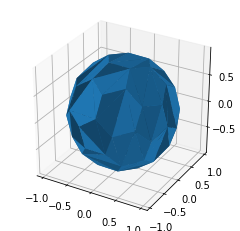

In [12]:
# Mesh and function space
#sphere = Sphere(Point(0.0, 0.0, 0.0), 1.0)
#vmesh = generate_mesh(sphere, 5)
#mesh = BoundaryMesh(vmesh, "exterior")
#plot(mesh)

#mesh = Mesh('LH/mesh.xml')
mesh = Mesh('LH/mesh_on_sphere_myself__reg_b700_700_del_fib0_1.xml')
plot(mesh)

In [13]:
for ind in nextIter_sub_indcs:
    print(ind)

0
2
3
4
7
8
10
11
13
15
16
18
20
23
25
28
31


In [14]:
for ind in sorted_true_sub_indcs:
    print(ind)

0
2
3
4
7
8
10
13
15
16
18
20
23
25
28
31


In [15]:
left_indcs

11

In [16]:
## Optimization options for the form compiler
#parameters["form_compiler"]["cpp_optimize"] = True
#parameters["form_compiler"]["optimize"] = True

In [17]:
## Make mesh ghosted for evaluation of DG terms
#parameters["ghost_mode"] = "shared_facet"

In [40]:
bvec_volPredict = reg_bvecs[left_indcs]
lh_coefs = np.zeros(len(sorted_true_sub_indcs))

for l in range(len(sorted_true_sub_indcs)):
    if sorted_true_sub_indcs[l] != 0:
        Element_BDM = FiniteElement("BDM", mesh.ufl_cell(), 1)
        Element_DG = FiniteElement("DG", mesh.ufl_cell(), 0)
        # Define the mixed element
        W_elem = MixedElement([Element_BDM, Element_DG])
        # Define the mixed function space
        W = FunctionSpace(mesh, W_elem)
        
        
        # get coordinates of DOFs
        dof_coords = W.tabulate_dof_coordinates()
        
        bcs = []
        for ind in sorted_true_sub_indcs:
            if ind!=0:
                if ind==sorted_true_sub_indcs[l]:
                    # find nearest DOF:
                    dof = np.argmin(np.linalg.norm(dof_coords - reg_bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof, dof_coords[dof]))
                    dof_sym = np.argmin(np.linalg.norm(dof_coords + reg_bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof_sym, dof_coords[dof_sym])) 

                    # now define a DirichletBC at that point
                    bcs.extend([DirichletBC(W.sub(1), Constant(1.0),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof][0], y=dof_coords[dof][1], z=dof_coords[dof][2]),
                                     'pointwise'),
                                DirichletBC(W.sub(1), Constant(1.0),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof_sym][0], y=dof_coords[dof_sym][1], z=dof_coords[dof_sym][2]),
                                     'pointwise')])
                else:
                    # find nearest DOF:
                    dof = np.argmin(np.linalg.norm(dof_coords - reg_bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof, dof_coords[dof]))
                    dof_sym = np.argmin(np.linalg.norm(dof_coords + reg_bvecs[ind], axis=1))
                    #print('dof {}, x = {}'.format(dof_sym, dof_coords[dof_sym])) 

                    # now define a DirichletBC at that point
                    bcs.extend([DirichletBC(W.sub(1), Constant(0.0),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof][0], y=dof_coords[dof][1], z=dof_coords[dof][2]),
                                     'pointwise'),
                                DirichletBC(W.sub(1), Constant(0.0),
                                     'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof_sym][0], y=dof_coords[dof_sym][1], z=dof_coords[dof_sym][2]),
                                     'pointwise')])
                    
        # Define trial and test functions
        #u = TrialFunction(V)
        #v = TestFunction(V)
        # Define trial and test functions
        (sigma, u) = TrialFunctions(W)
        (tau, v) = TestFunctions(W)

        # Define source function
        f = Constant(0.0)

        # Define variational form
        a = (dot(sigma, tau) + div(tau)*u + div(sigma)*v)*dx
        L = - f*v*dx
       
        # Compute solution
        w = Function(W)
        solve(a == L, w, bcs)
        (sigma, u) = w.split()
        
        lh_coefs[l] = u(bvec_volPredict)
        print(lh_coefs[l])
    else:
        lh_coefs[l] = 0
        print(lh_coefs[l])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [19]:
lh_coefs

array([ 0.        ,  0.05081537,  0.03543987,  0.36501141,  0.51185619,
        0.08157203, -0.05027305, -0.17725609, -0.05650711,  0.10584154,
        0.00595795, -0.15884553, -0.1879158 , -0.24620125,  0.02072951,
       -0.00753496])

In [20]:
sorted_true_sub_indcs[np.argsort(lh_coefs)]

array([25, 23, 13, 20, 15, 10, 31,  0, 18, 28,  3,  2,  8, 16,  4,  7])

In [21]:
len(lh_coefs[lh_coefs>0.01])

7

In [22]:
len(lh_coefs[lh_coefs<-0.01])

6

In [23]:
len(lh_coefs[lh_coefs!=0])

15

In [24]:
len(lh_coefs)

16

In [25]:
np.sum(lh_coefs)

0.29269009959756864

In [26]:
# Save solution to file in VTK format
vtkfile = File('multi_shell/solution.pvd')
vtkfile << u

In [35]:
inpaintedImg_3D = np.zeros((dims[0], dims[1], dims[2]))

it = 0
for i in range(len(sorted_true_sub_indcs)):
    print(it, i, sorted_true_sub_indcs[i], lh_coefs[i])
    if sorted_true_sub_indcs[i]!=0:
        #inpaintedImg_3D = inpaintedImg_3D + abs(lh_coefs[i])*sub_data[...,it]
        inpaintedImg_3D = inpaintedImg_3D + lh_coefs[i]*sub_data[...,it]
        it = it+1
inpaintedImg_3D = inpaintedImg_3D/np.sum(lh_coefs)
#inpaintedImg_3D = inpaintedImg_3D/np.sum(abs(lh_coefs))

0 0 0 0.0
0 1 2 0.050815374510645425
1 2 3 0.03543987254834544
2 3 4 0.3650114118447391
3 4 7 0.5118561869644759
4 5 8 0.08157202862315738
5 6 10 -0.0502730500066357
6 7 13 -0.1772560923152441
7 8 15 -0.056507105343330574
8 9 16 0.10584153928216482
9 10 18 0.005957954643016309
10 11 20 -0.15884553442387062
11 12 23 -0.18791579748802448
12 13 25 -0.24620124535509327
13 14 28 0.020729512231707038
14 15 31 -0.007534956118484062


In [28]:
max(inpaintedImg_3D.flatten())

410.96202425855955

In [29]:
bvec_volPredict

array([ 0.30594536,  0.9476918 , -0.09098167])

In [30]:
nameStr = "multi_shell/multi_fast_qspace_BH_volume_image_on_sphere_" + str(left_indcs) + "_dely_P2.nii.gz"
ni_img = nib.Nifti1Image(inpaintedImg_3D, affine=affine)
nib.save(ni_img, nameStr)

In [31]:
#array_u = nodal_values_u = w.vector()
#vertex_values_u = w.compute_vertex_values()

In [32]:
#for i in range(len(array_u)):
#    print(array_u[i])

In [33]:
#min(array_u)

In [34]:
#error_L2 = errornorm(u_D, w, 'L2')
#vertex_values_u_D = u_D.compute_vertex_values(mesh)
#vertex_values_u = w.compute_vertex_values(mesh)
#error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))
#print(error_max)
#print(error_L2)